<a href="https://colab.research.google.com/github/kluo9/Deep-Learning/blob/main/Advanced_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I will implement GAN with Wasserstein loss.
The target is to generate human faces, and I will also implement checkpoint in the code to allow the training process to be halted and reloaded.

In [1]:
# import libraries
import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show(tensor, num = 25, wandbactive = 0, name = ''):
  data = tensor.detach().cpu()
  grid = make_grid(data[:num], nrow = 5).permute(1,2,0)

  if (wandbactive == 1 and wandbact == 1):
    wandb.log({name:wandb.Image(grid.numpy().clip(0,1))})

  plt.imshow(grid.clip(0,1))
  plt.show()


In [3]:
# hyperparameters and general parameters
n_epochs = 10000
batch_size = 128
lr = 1e-4
z_dim = 200
device = 'cuda'

cur_step = 0
crit_cycles = 5
gen_loss = []
crit_loss = []
show_step = 35
save_step = 35

wandbact = 1


In [4]:
!pip install wandb -qqq
import wandb
wandb.login(key = '663bc1afe3686fa084793849df5c11dc70860853')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
%%capture
experiment_name = wandb.util.generate_id()

myrun = wandb.init(
    project = 'wgan',
    group = experiment_name,
    config = {
        "optimizer":"adam",
        "model":"wgan gp",
        "epoch":"1000",
        "batch_size":128
    }
)

config = wandb.config

In [6]:
print(experiment_name)

8va2ao0m


# Model structure

## generator model

In [7]:
from torch.nn.modules.activation import ReLU
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.conv import Conv2d
class Generator(nn.Module):
  def __init__(self, z_dim = 64, d_dim = 16):
    super(Generator, self).__init__()
    self.z_dim = z_dim

    self.gen = nn.Sequential(
        ## we begin with a 1*1 image with z_dim channels
        nn.ConvTranspose2d(z_dim, d_dim * 32, 4, 1, 0),  ## 4*4 image (channels: 200 to 512)
        nn.BatchNorm2d(d_dim * 32),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 32, d_dim * 16, 4, 2, 1),  ## 8*8 image (channels: 512 to 256)
        nn.BatchNorm2d(d_dim * 16),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 16, d_dim * 8, 4, 2, 1),  ## 16*16 image (channels: 256 to 128)
        nn.BatchNorm2d(d_dim * 8),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 8, d_dim * 4, 4, 2, 1),  ## 32*32 image (channels: 128 to 64)
        nn.BatchNorm2d(d_dim * 8),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 4, d_dim * 2, 4, 2, 1),  ## 64*64 image (channels: 64 to 32)
        nn.BatchNorm2d(d_dim * 2),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 2, 3, 4, 2, 1),  ## 128*128 image (channels: 32 to 3)
        nn.Tanh()  # produce the result in the range from -1 to 1
    )
  def forward(self, noise):
    x = noise.view(len(noise), self.z_dim, 1, 1)
    return self.gen(noise) # 128 (batch) * 200 (chanel) * 1 * 1

def gen_noise(num, z_dim, device = 'cuda'):
  return torch.randn(num, z_dim, device=device) # 128*200

## Critic model

In [8]:
class Critic(nn.Module):
  def __init__(self, d_dim = 16):
    super(Critic, self).__init__()

    self.critic = nn.Sequential(
        nn.Conv2d(3, d_dim, 4, 2, 1),  # 128*128*3 to 64*64*16
        nn.InstanceNorm2d(d_dim),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim, d_dim * 2, 4, 2, 1),  # 64*64*16 to 32*32*32
        nn.InstanceNorm2d(d_dim * 2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim * 2, d_dim * 4, 4, 2, 1),  #  32*32*32 to 16*16*64
        nn.InstanceNorm2d(d_dim * 4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim * 4, d_dim * 8, 4, 2, 1),  # 16*16*64 to 8*8*128
        nn.InstanceNorm2d(d_dim * 8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim * 8, d_dim * 16, 4, 2, 1),  # 8*8*128 to 4*4*256
        nn.InstanceNorm2d(d_dim * 16),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim * 16, 1, 4, 1, 0),  # 4*4*256 to 1*1*1

    )
  def forward(self, image):
    # image: 128*3*128*128
    crit_pred = self.critic(image) # 128*1*1*1
    return crit_pred.view(len(crit_pred), -1) # 128*1

In [9]:
## optional: init weights in different ways
def init_weights(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

    if isinstance(m, nn.BatchNorm2d):
      torch.nn.init.normal_(m.weight, 0.0, 0.02)
      torch.nn.init.constant_(m.bias, 0)



# Load dataset

In [20]:
import gdown, zipfile
# url = "https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=drive_link&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ"
path = "/content/data/celeba"
download_path = f'{path}/img_align_celeba.zip'

if not os.path.exists(path):
  os.makedirs(path)

# gdown.download(url, download_path, quiet=False)

In [12]:
from google.colab import files


uploaded = files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [16]:
%cd /content/data/celeba
! kaggle datasets download jessicali9530/celeba-dataset

/content/data/celeba
 99% 1.32G/1.33G [00:05<00:00, 252MB/s]
100% 1.33G/1.33G [00:05<00:00, 253MB/s]


In [21]:
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(path)

## Dataset and DataLoader

In [37]:
class Dataset(Dataset):
  def __init__(self, path, size=128, lim=10000):
    self.sizes = [size, size]
    items, labels = [], [] # hold path to the images

    for data in os.listdir(path)[:lim]:
      # path: '/content/data/celeba/img_align_celeba'
      # data: 114568.jpg
      item = os.path.join(path,data)
      items.append(item)
      labels.append(data)
    self.items = items
    self.labels = labels

  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):
    data = PIL.Image.open(self.items[idx]).convert('RGB') # original image
    data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) # resize image to 128*128*3
    data = np.transpose(data, (2,0,1)).astype(np.float32, copy = False) # 3*128*128 from 0 to 255
    data = torch.from_numpy(data).div(255) # from 0 to 1
    return data, self.labels[idx]

In [47]:
## Dataset
data_path = data_path = '/content/data/celeba/img_align_celeba/img_align_celeba'
ds = Dataset(data_path, size = 128, lim = 10000)

## DataLoader
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

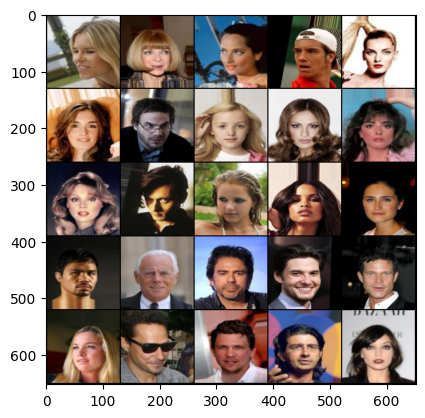

In [48]:
## models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

## optimizer
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.9))
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5, 0.9))

## initionlization
# gen = gen.apply(init_weights)
# crit = crit.apply(init_weights)

## wandb
if (wandbact == 1):
  wandb.watch(gen, log_freq=100)
  wandb.watch(crit, log_freq=100)

x,y = next(iter(dataloader))
show(x)